Custom Models in BoTorch

In [1]:
import torch

# Set the seed for reproducibility
torch.manual_seed(1)
# Double precision is highly recommended for BoTorch.
# See https://github.com/meta-pytorch/botorch/discussions/1444
torch.set_default_dtype(torch.float64)

train_X = torch.rand(20, 2) * 2
Y = 1 - (train_X - 0.5).norm(dim=-1, keepdim=True)
Y += 0.1 * torch.rand_like(Y)
bounds = torch.stack([torch.zeros(2), 2 * torch.ones(2)])

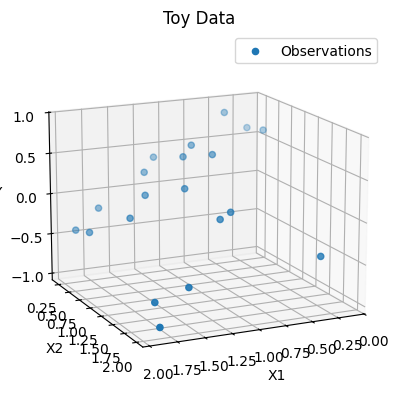

In [2]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from torch import Tensor
from mpl_toolkits.mplot3d import Axes3D

# Needed for older versions of matplotlib.
assert Axes3D


def plot_toy_data(x: Tensor, y: Tensor) -> Axes:
    ax = plt.figure().add_subplot(projection="3d")
    ax.scatter(
        x[:, 0].detach().numpy().squeeze(),
        x[:, 1].detach().numpy().squeeze(),
        zs=y.detach().numpy().squeeze(),
        label="Observations",
    )
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("Y")
    ax.set_title("Toy Data")
    ax.view_init(elev=15.0, azim=65)
    ax.legend()
    return ax


plot_toy_data(x=train_X, y=Y)
plt.show()

Probabilistic Linear Regression (w/ Torch Distributions)

In [3]:
from typing import Optional, Union
from torch import Tensor, distributions, nn
from botorch.acquisition.objective import PosteriorTransform
from botorch.models.model import Model
from botorch.posteriors.posterior import Posterior
from botorch.posteriors.torch import TorchPosterior


class ProbabilisticRegressionModel(Model):
    _num_outputs: int

    def __init__(self, train_X: Tensor, train_Y: Tensor):
        super(ProbabilisticRegressionModel, self).__init__()
        self._num_outputs = train_Y.shape[-1]
        # Linear layer that will compute the regression output.
        self.linear = nn.Linear(train_X.shape[-1], self.num_outputs)

    @property
    def num_outputs(self) -> int:
        return self._num_outputs

    def forward(self, x: Tensor) -> distributions.Distribution:
        # For now, let's suppose we have known variance 1.
        return distributions.StudentT(df=3., loc=self.linear(x), scale=1)

    def posterior(
        self,
        X: Tensor,
        output_indices: Optional[list[int]] = None,
        observation_noise: Union[bool, Tensor] = False,
        posterior_transform: Optional[PosteriorTransform] = None,
    ) -> Posterior:
        if output_indices:
            X = X[..., output_indices]
        # TorchPosterior directly wraps our torch.distributions.Distribution output.
        posterior = TorchPosterior(distribution=self(X))
        if posterior_transform is not None:
            posterior = posterior_transform(posterior)
        return posterior

In [4]:
def fit_prob_reg(
    epochs: int,
    model: ProbabilisticRegressionModel,
    optimizer: torch.optim.Optimizer,
    train_X: Tensor,
    train_Y: Tensor,
) -> None:
    """Optimization loop for linear regression."""
    train_X = train_X.requires_grad_()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_X)
        loss = -outputs.log_prob(train_Y).mean()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print("epoch {}, loss {}".format(epoch, loss.item()))

In [5]:
prob_regression_model = ProbabilisticRegressionModel(train_X, Y)
optimizer = torch.optim.Adam(prob_regression_model.parameters(), lr=0.1)
fit_prob_reg(50, prob_regression_model, optimizer, train_X, Y)

epoch 0, loss 1.4067664345474094
epoch 10, loss 1.1349407118418473
epoch 20, loss 1.0426907808272752
epoch 30, loss 1.0281791195725947
epoch 40, loss 1.0313219974336634


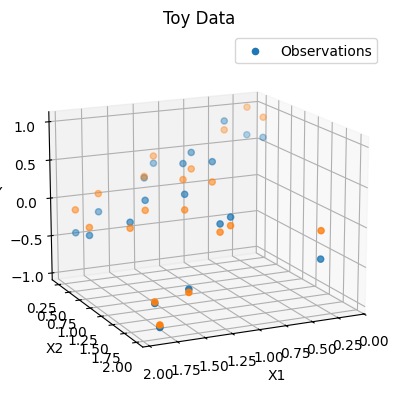

In [6]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=prob_regression_model(train_X).mean.detach().squeeze().numpy(),
)
plt.show()

In [7]:
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim.optimize import optimize_acqf

candidate, acq_val = optimize_acqf(
    LogExpectedImprovement(model=prob_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)
candidate, acq_val

(tensor([[0., 0.]]), tensor(-0.1333))

In [8]:
from botorch.sampling.base import MCSampler
from botorch.sampling.get_sampler import GetSampler
from botorch.sampling.stochastic_samplers import ForkedRNGSampler


@GetSampler.register(distributions.StudentT)
def _get_sampler_torch(
    posterior: TorchPosterior,
    sample_shape: torch.Size,
    *,
    seed: Optional[int] = None,
) -> MCSampler:
    # Use `ForkedRNGSampler` to ensure determinism in acquisition function evaluations.
    return ForkedRNGSampler(sample_shape=sample_shape, seed=seed)

In [9]:
from botorch.acquisition.logei import qLogExpectedImprovement

optimize_acqf(
    qLogExpectedImprovement(model=prob_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-0.1924))

In [10]:
print(
    [
        j.__name__
        for j in [getattr(distributions, i) for i in distributions.__all__]
        if hasattr(j, "has_rsample") and j.has_rsample
    ]
)

['Beta', 'Cauchy', 'Chi2', 'ContinuousBernoulli', 'Dirichlet', 'Exponential', 'FisherSnedecor', 'Gamma', 'GeneralizedPareto', 'Gumbel', 'HalfCauchy', 'HalfNormal', 'Independent', 'InverseGamma', 'Kumaraswamy', 'Laplace', 'LogNormal', 'LogisticNormal', 'LowRankMultivariateNormal', 'MultivariateNormal', 'Normal', 'OneHotCategoricalStraightThrough', 'Pareto', 'RelaxedBernoulli', 'RelaxedOneHotCategorical', 'StudentT', 'Uniform', 'Weibull', 'Wishart', 'TransformedDistribution']


Bayesian Linear Regression

In [11]:
from typing import Optional, Union
from torch import Tensor, distributions, nn
from botorch.acquisition.objective import PosteriorTransform
from botorch.models.model import Model
from botorch.posteriors.posterior import Posterior
from botorch.posteriors.torch import TorchPosterior


def add_intercept(x: Tensor) -> Tensor:
    """Adds an intercept column to the design matrix (i.e. tensor)."""
    return torch.concat([torch.ones_like(x)[..., 0:1], x], dim=-1)


class BayesianRegressionModel(Model):
    _num_outputs: int
    df: int
    s_squared: Tensor
    beta: Tensor
    L: Tensor
    add_intercept: bool

    def __init__(self, intercept: bool = True) -> None:
        super(BayesianRegressionModel, self).__init__()
        self.add_intercept = intercept

    @property
    def num_outputs(self) -> int:
        return self._num_outputs

    def forward(self, x: Tensor) -> Tensor:
        return x @ self.beta

    def fit(self, x: Tensor, y: Tensor) -> None:
        self._num_outputs = y.shape[-1]
        x = add_intercept(x) if self.add_intercept else x
        self.df = 3.
        # Rather than V = torch.linalg.inv(x.T @ x) as in BDA
        # instead use L = torch.linalg.cholesky(x.T @ x) for stability.
        # To use L, we can simply replace operations like:
        # x = V @ b
        # with a call to `torch.cholesky_solve`:
        # x = torch.cholesky_solve(b, L)
        self.L = torch.linalg.cholesky(x.T @ x)
        # Least squares estimate
        # self.beta = torch.cholesky_solve(x.T, self.L) @ y
        self.beta = torch.cholesky_solve(x.T, self.L) @ y
        # Model's residuals from the labels.
        r: Tensor = y - self(x)
        # Sample variance
        self.s_squared = (1 / self.df) * r.T @ r

    def posterior(
        self,
        X: Tensor,
        output_indices: Optional[list[int]] = None,
        observation_noise: Union[bool, Tensor] = False,
        posterior_transform: Optional[PosteriorTransform] = None,
    ) -> Posterior:
        if output_indices:
            X = X[..., output_indices]
        if self.add_intercept:
            X = add_intercept(X)

        n, q, d = X.shape # only evaluating shape, after shape feature changes
        assert q == 1, "Only one query point is supported"
        loc = self(X)
        # Full covariance matrix of all test points.
        cov = self.s_squared * (
            torch.eye(n, n) + X.view(-1,d) @ torch.cholesky_solve(X.view(-1,d).T, self.L)
        )
        # The batch semantics of BoTorch evaluate each data point in their own batch.
        # So, we extract the diagonal representing Var[\tilde y_i | y_i] of each test point.
        scale = torch.diag(cov).reshape(n, q, self.num_outputs)
        # Form the posterior predictive dist according to Sec 14.2, Pg 357 of BDA.
        posterior_predictive_dist = distributions.StudentT(
            df=self.df, loc=loc, scale=scale
        )
        posterior = TorchPosterior(distribution=posterior_predictive_dist)
        if posterior_transform is not None:
            posterior = posterior_transform(posterior)
        return posterior

In [12]:
bayesian_regression_model = BayesianRegressionModel(intercept=True)
bayesian_regression_model.fit(train_X, Y)

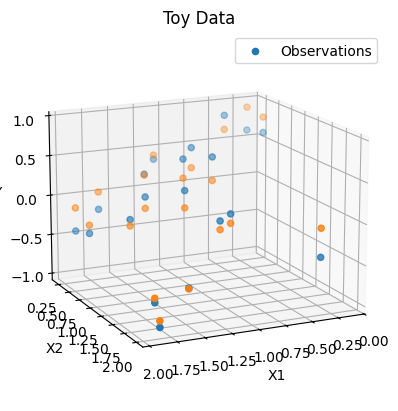

In [13]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=bayesian_regression_model(add_intercept(train_X)).detach().squeeze().numpy(),
)
plt.show()

In [14]:
optimize_acqf(
    LogExpectedImprovement(model=bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-0.9797))

In [15]:
optimize_acqf(
    qLogExpectedImprovement(model=bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-1.0001))

Bayesian Linear Regression w/ EnsemblePosterior

In [16]:
mask = False
model = torch.no_grad()
(poutine.mask(model, mask=False) if mask else model)

In [17]:
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import PyroOptim

pyro.set_rng_seed(1)


# Bayesian Regression represented as a single hidden layer.
class BayesianRegression(PyroModule):
    Y: str = "y"

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        # Linear layer like before, but wrapped with PyroModule.
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # Add priors to the weights & bias of the linear layer.
        self.linear.weight = PyroSample(
            dist.Normal(0.0, 1.0)
            .expand(torch.Size([out_features, in_features]))
            .to_event(2)
        )
        self.linear.bias = PyroSample(
            dist.Normal(0.0, 10.0).expand(torch.Size([out_features])).to_event(1)
        )

    def forward(self, x: Tensor, y: Optional[Tensor] = None) -> Tensor:
        # NOTE: Enable gradient tracking to override behavior of `Predictive`.
        torch.set_grad_enabled(True)
        # Prior for the noise level.
        sigma = pyro.sample("sigma", dist.Uniform(0.0, 10.0))
        # Linear layer on the inputs.
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            # Observations will be t distributed.
            t_dist = dist.StudentT(df=3., loc=mean, scale=sigma)
            _ = pyro.sample(self.Y, t_dist, obs=y)
        return mean

In [18]:
def fit_svi(
    epochs: int,
    model: PyroModule,
    guide: AutoGuide,
    optimizer: PyroOptim,
    train_X: Tensor,
    train_Y: Tensor,
) -> None:
    svi = SVI(
        model,
        guide,
        optimizer,
        loss=Trace_ELBO(),
    )
    pyro.clear_param_store()
    for epoch in range(epochs):
        loss = svi.step(train_X, train_Y.squeeze())
        if epoch % 10 == 0:
            print("epoch {}, loss {}".format(epoch, loss))

In [19]:
from botorch.models.ensemble import EnsembleModel
from pyro.infer import Predictive

class EnsembleBayesianRegressionModel(EnsembleModel):
    model: BayesianRegression
    guide: AutoGuide
    num_samples: int
    _num_outputs: int

    def __init__(self, train_X: Tensor, train_Y: Tensor, num_samples: int = 100):
        super(EnsembleBayesianRegressionModel, self).__init__()
        self._num_outputs = train_Y.shape[-1]
        self.model = BayesianRegression(train_X.shape[-1], self.num_outputs)
        self.guide = AutoDiagonalNormal(self.model)
        self.num_samples = num_samples

    def forward(self, X: Tensor) -> Tensor:
        predictive = Predictive(
            self.model,
            guide=self.guide,
            num_samples=self.num_samples,
            # Only return the posterior predictive distribution for y.
            return_sites=(self.model.Y,),
        )
        # `EnsemblePosterior` expects a `(b) x s x q x m` tensor where `m` is the
        # output size of the model and `s` is the ensemble size.
        samples = (
            # Retrieve posterior samples from the observation random variable.
            # This is also known as a posterior predictive distribution.
            predictive(X.squeeze())[self.model.Y]
            # Move the ensemble dimension to "s" axis.
            .transpose(0, 1)
            # Reshape for `EnsemblePosterior` as mentioned above.
            .reshape(X.shape[0], -1, 1, self.num_outputs)
        )
        return samples

In [20]:
ensemble_bayesian_regression_model = EnsembleBayesianRegressionModel(
    train_X=train_X, train_Y=Y
)
fit_svi(
    100,
    ensemble_bayesian_regression_model.model,
    ensemble_bayesian_regression_model.guide,
    pyro.optim.Adam({"lr": 0.1}),
    train_X,
    Y,
)

epoch 0, loss 59.37405385761919
epoch 10, loss 48.79479142734722
epoch 20, loss 29.67741235810953
epoch 30, loss 33.595642536471374
epoch 40, loss 60.80503562352027
epoch 50, loss 32.285903651999185
epoch 60, loss 31.12178365362242
epoch 70, loss 22.872947363325892
epoch 80, loss 11.570201108416097
epoch 90, loss 16.887300159131286


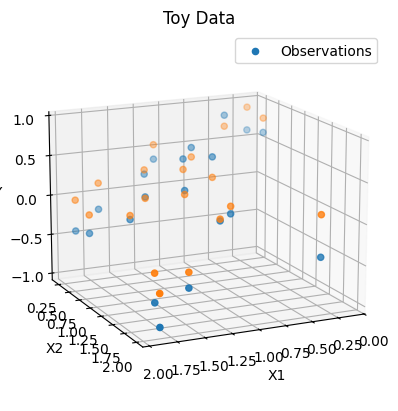

In [21]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=ensemble_bayesian_regression_model(train_X)
    .detach()
    .squeeze()
    .mean(dim=-1)
    .numpy(),
)
plt.show()

In [22]:
optimize_acqf(
    LogExpectedImprovement(model=ensemble_bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-1.1305))

In [23]:
optimize_acqf(
    qLogExpectedImprovement(model=ensemble_bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-1.1052))

Random Forest w/ Ensemble Posterior

In [24]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from botorch.models.ensemble import EnsembleModel


class EnsembleRandomForestModel(EnsembleModel):
    model: RandomForestRegressor
    num_samples: int
    _num_outputs: int

    def __init__(self, num_samples: int = 100):
        super(EnsembleRandomForestModel, self).__init__()
        self._num_outputs = 1
        self.model = RandomForestRegressor(n_estimators=num_samples)

    def fit(self, X: Tensor, y: Tensor) -> None:
        self.model = self.model.fit(
            X=X.detach().numpy(), y=y.detach().numpy().squeeze()
        )

    def forward(self, X: Tensor) -> Tensor:
        x = X.detach().numpy().squeeze()
        # Create the ensemble from predictions from each decision tree.
        y = torch.from_numpy(np.array([i.predict(x) for i in self.model.estimators_]))
        # `EnsemblePosterior` expects a `(b) x s x q x m` tensor where `m` is the
        # output size of the model and `s` is the ensemble size.
        samples = y.transpose(0, 1).reshape(X.shape[0], -1, 1, self.num_outputs)
        return samples

In [25]:
ensemble_random_forest_model = EnsembleRandomForestModel(num_samples=300)
ensemble_random_forest_model.fit(X=train_X, y=Y)

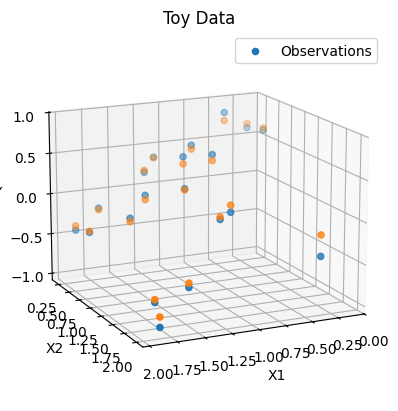

In [26]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=ensemble_random_forest_model(train_X).detach().squeeze().mean(dim=-1).numpy(),
)
plt.show()

In [27]:
optimize_acqf(
    LogExpectedImprovement(model=ensemble_random_forest_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
    options={"with_grad": False},
)

(tensor([[0.5480, 0.3606]]), tensor(-3.5043))

In [28]:
optimize_acqf(
    qLogExpectedImprovement(model=ensemble_random_forest_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
    options={"with_grad": False},
)

(tensor([[0.7104, 0.1625]]), tensor(-15.0281))

CMA-ES

In [29]:
import cma
import numpy as np

x0 = np.random.rand(2)

es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.2,
    inopts={"bounds": [0, 2], "popsize": 50},
)

log_expected_improvement_ensemble_random_forest_model = LogExpectedImprovement(
    model=ensemble_random_forest_model, best_f=Y.max()
)

with torch.no_grad():
    while not es.stop():
        xs = es.ask()
        y = (
            -log_expected_improvement_ensemble_random_forest_model(
                torch.from_numpy(np.array(xs)).unsqueeze(-2)
            )
            .view(-1)
            .double()
            .numpy()
        )
        es.tell(xs, y)

torch.from_numpy(es.best.x)

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=917729, Mon Jan 19 21:27:12 2026)


tensor([0.3423, 0.8581])

# Optimize acquisition functions using CMA-ES

In [30]:
import math
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

X = torch.rand(20, 2) - 0.5
Y = (torch.sin(2 * math.pi * X[:, 0]) + torch.cos(2 * math.pi * X[:, 1])).unsqueeze(-1)
Y += 0.1 * torch.randn_like(Y)

gp = SingleTaskGP(X, Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

import cma
import numpy as np

# get initial condition for CMAES in numpy form
# note that CMAES expects a different shape (no explicit q-batch dimension)
x0 = np.random.rand(2)

# create the CMA-ES optimizer
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.2,
    inopts={"bounds": [0, 1], "popsize": 50},
)

# speed up things by telling pytorch not to generate a compute graph in the background
with torch.no_grad():

    # Run the optimization loop using the ask/tell interface -- this uses
    # PyCMA's default settings, see the PyCMA documentation for how to modify these
    while not es.stop():
        xs = es.ask()  # as for new points to evaluate
        # convert to Tensor for evaluating the acquisition function
        X = torch.tensor(xs, device=X.device, dtype=X.dtype)
        # evaluate the acquisition function (optimizer assumes we're minimizing)
        Y = -UCB(
            X.unsqueeze(-2)
        )  # acquisition functions require an explicit q-batch dimension
        y = Y.view(-1).cpu().double().numpy()  # convert result to numpy array
        es.tell(xs, y)  # return the result to the optimizer

# convert result back to a torch tensor
best_x = torch.from_numpy(es.best.x).to(X)

best_x

/mnt/c/Users/james/projects/botorch-custom-surrogate-experiment/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:271: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/tmp/ipykernel_7159/1424227434.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X = torch.tensor(xs, device=X.device, dtype=X.dtype)


(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=900170, Mon Jan 19 21:27:12 2026)


tensor([2.3755e-01, 1.7269e-15])

# Pure Active Learning

In [31]:
import numpy as np
import scipy.stats
import torch
from botorch import acquisition, sampling
from botorch.acquisition.objective import ScalarizedPosteriorTransform, ConstrainedMCObjective
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.box_decompositions import FastNondominatedPartitioning
from gpytorch.mlls import ExactMarginalLogLikelihood
from tqdm.notebook import trange

X = torch.rand(20, 2) - 0.5
Y = (torch.sin(2 * math.pi * X[:, 0]) + torch.cos(2 * math.pi * X[:, 1])).unsqueeze(-1)
Y += 0.1 * torch.randn_like(Y)

gp = SingleTaskGP(X, Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

from botorch.acquisition import UpperConfidenceBound

posterior_transform = ScalarizedPosteriorTransform(
    weights=torch.ones(Y.shape[1], dtype=torch.double))

acq = acquisition.PosteriorStandardDeviation(
    gp,
    posterior_transform=posterior_transform,
)

import cma
import numpy as np

# get initial condition for CMAES in numpy form
# note that CMAES expects a different shape (no explicit q-batch dimension)
x0 = np.random.rand(2)

# create the CMA-ES optimizer
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.2,
    inopts={"bounds": [0, 1], "popsize": 50},
)

# speed up things by telling pytorch not to generate a compute graph in the background
with torch.no_grad():

    # Run the optimization loop using the ask/tell interface -- this uses
    # PyCMA's default settings, see the PyCMA documentation for how to modify these
    while not es.stop():
        xs = es.ask()  # as for new points to evaluate
        # convert to Tensor for evaluating the acquisition function
        X = torch.tensor(xs, device=X.device, dtype=X.dtype)
        # evaluate the acquisition function (optimizer assumes we're minimizing)
        Y = -acq(
            X.unsqueeze(-2)
        )  # acquisition functions require an explicit q-batch dimension
        y = Y.view(-1).cpu().double().numpy()  # convert result to numpy array
        es.tell(xs, y)  # return the result to the optimizer

# convert result back to a torch tensor
best_x = torch.from_numpy(es.best.x).to(X)

best_x

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=987135, Mon Jan 19 21:27:12 2026)


/mnt/c/Users/james/projects/botorch-custom-surrogate-experiment/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:271: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


tensor([1.0000, 1.0000])